# Peter och vargen: Realistisk miljö

I vår situation kunde Peter röra sig nästan utan att bli trött eller hungrig. I en mer realistisk värld måste han sätta sig ner och vila då och då, och även äta för att hålla sig mätt. Låt oss göra vår värld mer realistisk genom att implementera följande regler:

1. När Peter rör sig från en plats till en annan förlorar han **energi** och får en viss **trötthet**.
2. Peter kan få mer energi genom att äta äpplen.
3. Peter kan bli av med trötthet genom att vila under ett träd eller på gräset (dvs. gå in på en plats på spelplanen med ett träd eller gräs - grönt fält).
4. Peter måste hitta och döda vargen.
5. För att kunna döda vargen måste Peter ha vissa nivåer av energi och trötthet, annars förlorar han striden.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

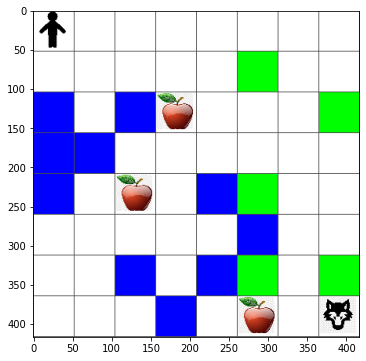

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definiera tillstånd

I våra nya spelregler behöver vi hålla koll på energi och trötthet vid varje brädposition. Därför kommer vi att skapa ett objekt `state` som innehåller all nödvändig information om det aktuella problemtillståndet, inklusive brädets tillstånd, aktuella nivåer av energi och trötthet, samt om vi kan besegra vargen vid slutläget:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Låt oss försöka lösa problemet med hjälp av slumpvandring och se om vi lyckas:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Belöningsfunktion

### Introduktion
Belöningsfunktionen är en viktig komponent i att definiera hur en agent ska bete sig i en given miljö. Den hjälper till att styra agentens beslut genom att tilldela poäng baserat på dess handlingar.

### Grundläggande principer
- Belöningar bör vara utformade för att uppmuntra önskade beteenden.
- Straff kan användas för att avskräcka oönskade beteenden.
- En välbalanserad belöningsfunktion är avgörande för att uppnå optimala resultat.

### Exempel på belöningsfunktion
Nedan följer ett exempel på hur en belöningsfunktion kan implementeras:

```python
def reward_function(params):
    # Extrahera relevanta parametrar
    speed = params['speed']
    distance_from_center = params['distance_from_center']
    track_width = params['track_width']

    # Beräkna belöning baserat på position på banan
    if distance_from_center < 0.1 * track_width:
        reward = 1.0  # Hög belöning för att hålla sig nära mitten
    else:
        reward = 0.5  # Lägre belöning för att vara längre från mitten

    # Justera belöning baserat på hastighet
    reward *= speed

    return reward
```

### Vanliga misstag
- **Överkomplicerade belöningsfunktioner**: Försök att hålla belöningsfunktionen enkel och lätt att förstå.
- **Felaktiga parametrar**: Se till att använda rätt parametrar för att undvika oväntade beteenden.
- **Obalanserade belöningar**: Om belöningarna är för höga eller för låga kan det leda till suboptimala resultat.

### Tips för att designa en effektiv belöningsfunktion
- Testa belöningsfunktionen i olika scenarier för att säkerställa att den fungerar som avsett.
- Analysera agentens beteende och justera belöningsfunktionen vid behov.
- Dokumentera tydligt hur belöningsfunktionen är utformad och vilka parametrar den använder.

### Slutsats
En välutformad belöningsfunktion är avgörande för att styra agentens beteende och uppnå önskade mål. Genom att följa bästa praxis och undvika vanliga misstag kan du skapa en belöningsfunktion som är både effektiv och robust.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning-algoritm

Själva inlärningsalgoritmen förblir i stort sett oförändrad, vi använder bara `state` istället för enbart brädposition.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

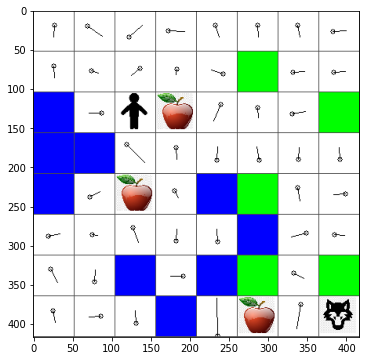

In [11]:
m.plot(Q)

## Resultat

Låt oss se om vi lyckades träna Peter att bekämpa vargen!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Vi ser nu mycket färre fall av drunkning, men Peter kan fortfarande inte alltid döda vargen. Försök att experimentera och se om du kan förbättra detta resultat genom att justera hyperparametrar.


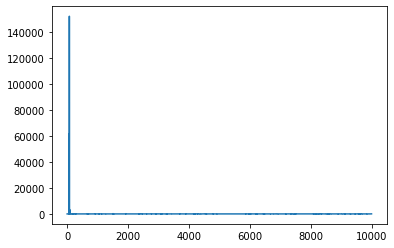

In [13]:
plt.plot(lpath)


---

**Ansvarsfriskrivning**:  
Detta dokument har översatts med hjälp av AI-översättningstjänsten [Co-op Translator](https://github.com/Azure/co-op-translator). Även om vi strävar efter noggrannhet, bör du vara medveten om att automatiserade översättningar kan innehålla fel eller felaktigheter. Det ursprungliga dokumentet på dess originalspråk bör betraktas som den auktoritativa källan. För kritisk information rekommenderas professionell mänsklig översättning. Vi ansvarar inte för eventuella missförstånd eller feltolkningar som uppstår vid användning av denna översättning.
